# Optimización de Portafolio con Cambios de Regimen


El siguiente trabajo apunta a presentar un modelo de Optimización de Portafolio donde uno de los activos tiene cambios de regimen. En este sentido la Optimización depende de la distribución de probabilidad del regimen.

In [256]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from scipy.stats import norm


In [ ]:
# Set seed for reproducibility
seed_1 = 1010

np.random.seed(seed_1)


# Como pensamos un activo con estos multiples


En este caso decidimos usar Cadenas de Markov para pensar los distintos estados que puede transitar un activo. 

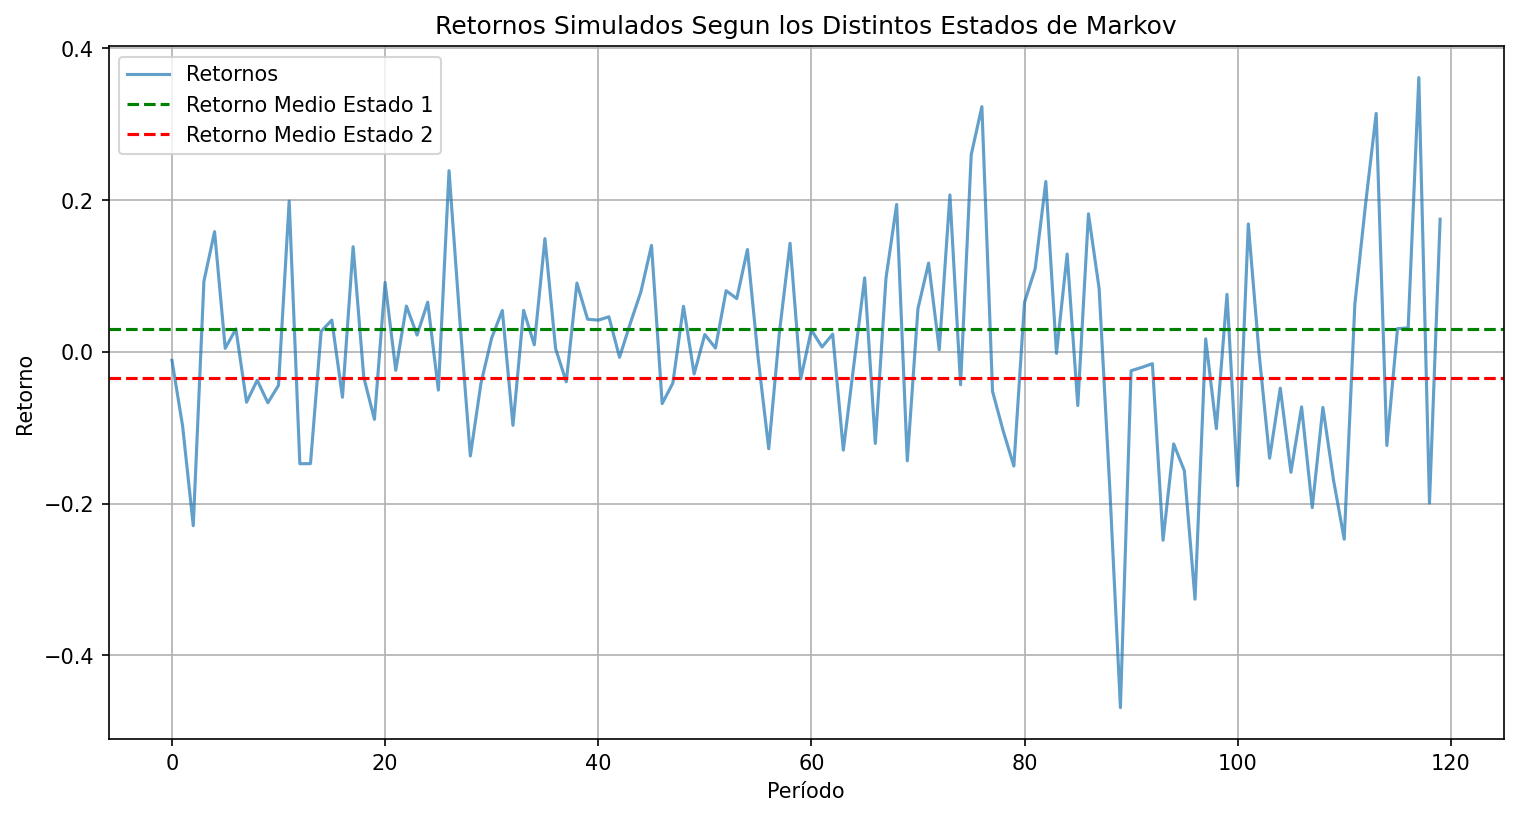

Retorno promedio: 0.26%
Volatilidad: 13.16%


In [258]:
np.random.seed(seed_1)

# Función para simular cadena de Markov y retornos
def simulate_markov_chain_and_returns(P, n_steps, state_means, state_stds, initial_state=0):
    """
    Simula una cadena de Markov y genera retornos basados en las transiciones de estado.

    Parámetros:
        P (numpy.ndarray): Matriz de transición.
        n_steps (int): Número de pasos a simular.
        state_means (list): Retornos promedio para cada estado.
        state_stds (list): Desviaciones estándar para cada estado.
        initial_state (int): Estado inicial de la cadena de Markov.

    Retorna:
        list: Estados simulados.
        list: Retornos simulados basados en las transiciones de estado.
    """
    current_state = initial_state
    states = [current_state]
    returns = []

    for _ in range(n_steps):
        next_state = np.random.choice([0, 1], p=P[current_state])
        states.append(next_state)
        current_state = next_state

        # Generar retorno basado en el estado actual
        state_return = np.random.normal(state_means[current_state], state_stds[current_state])
        returns.append(state_return)

    return states, returns

# Definir variables para ejemplo empírico
P = np.array([[0.982609, 0.017391],  # Matriz de transición
              [0.031746, 0.968254]])
n_steps = 120  # Número de pasos
state_means = [0.030639089580740655, -0.035002093505550835]  # Retornos promedio por estado
state_stds = [0.1026050519282914, 0.1724307100805829]  # Desviaciones estándar por estado

# Llamar a la función
states, eq_em_returns = simulate_markov_chain_and_returns(P, n_steps, state_means, state_stds)

# Graficar retornos simulados
plt.figure(figsize=(12, 6))
plt.plot(eq_em_returns, label="Retornos", alpha=0.7)
plt.axhline(y=state_means[0], color="green", linestyle="--", label="Retorno Medio Estado 1")
plt.axhline(y=state_means[1], color="red", linestyle="--", label="Retorno Medio Estado 2")
plt.title("Retornos Simulados Segun los Distintos Estados de Markov")
plt.xlabel("Período")
plt.ylabel("Retorno")
plt.legend()
plt.grid()
plt.show()

print(f"Retorno promedio: {np.mean(eq_em_returns):.2%}")
print(f"Volatilidad: {np.std(eq_em_returns):.2%}")

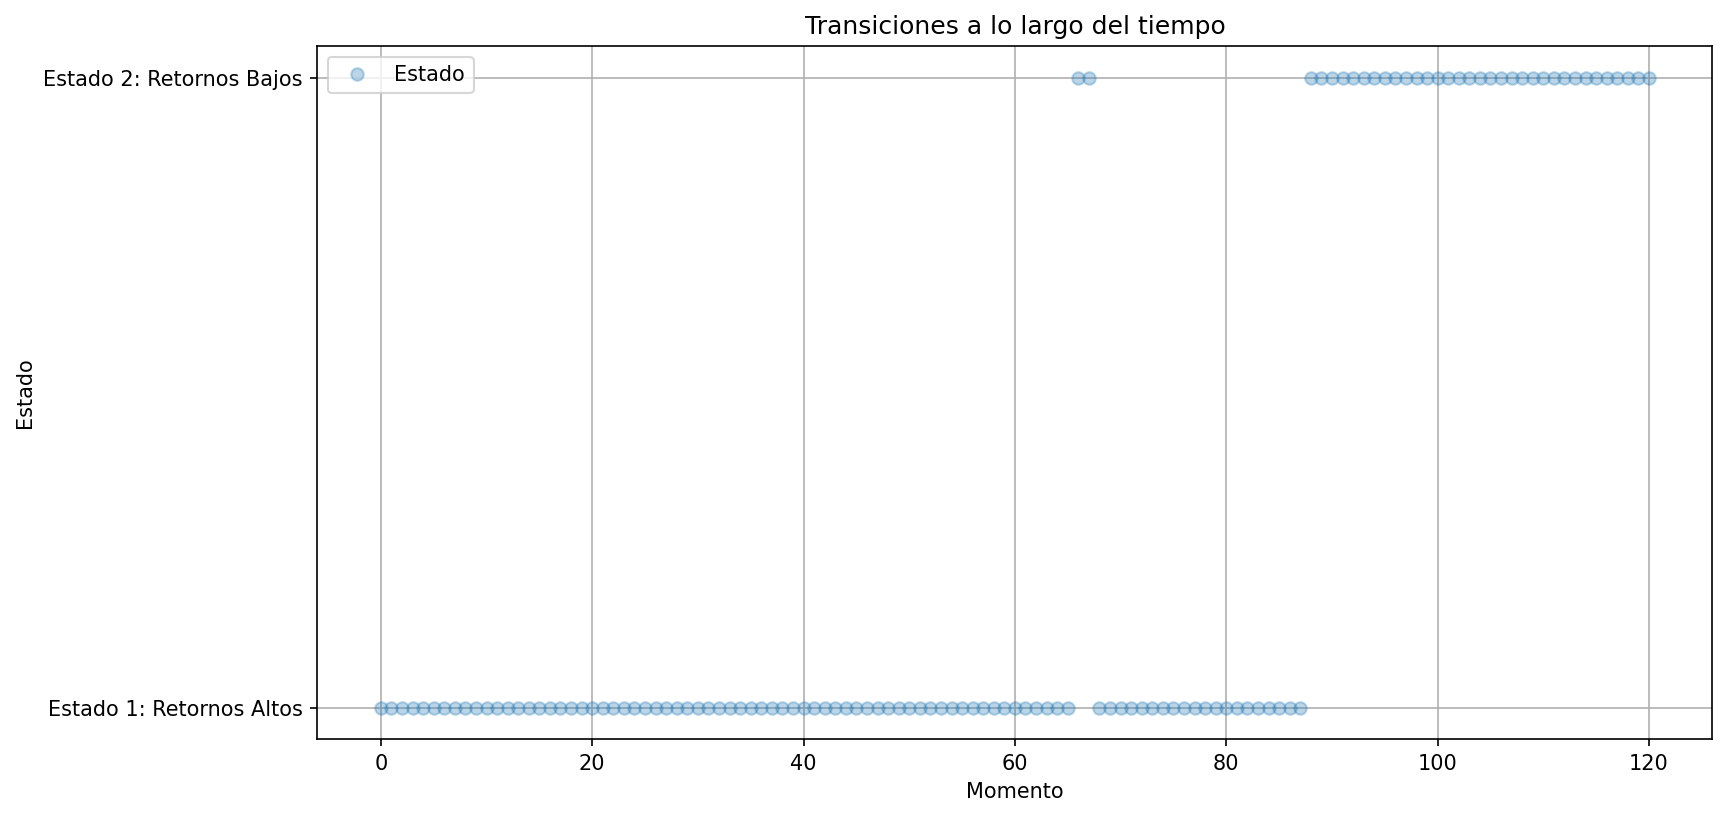

In [259]:
# Plot the states over time
plt.figure(figsize=(12, 6))
plt.plot(states, marker="o", linestyle="", alpha=0.3, label="Estado")
plt.title("Transiciones a lo largo del tiempo")
plt.xlabel("Momento")
plt.ylabel("Estado")
plt.yticks([0, 1], ["Estado 1: Retornos Altos", "Estado 2: Retornos Bajos"])
plt.legend()
plt.grid()
plt.show()


In [260]:
np.random.seed(seed_1)

# Generar datos simulando equity global y libre de riesgo
rolling_window = 12
rf_returns = np.full(n_steps, 0.00327)  # Retornos constantes libres de riesgo
eq_returns = np.random.normal(0.01, 0.15, n_steps)  # Retornos de equity global

returns = np.vstack([rf_returns, eq_returns, eq_em_returns]).T

In [261]:
# Function to compute portfolio variance
def portfolio_variance(w, sigma):
    return np.dot(w.T, np.dot(sigma, w))

In [262]:
# Función de optimización de portafolio
def optimize_portfolio(mu, sigma, target_return=0.0003):
    n_assets = len(mu)
    w0 = np.array([1/n_assets] * n_assets)  # Pesos iguales como punto de partida
    constraints = [
        {"type": "eq", "fun": lambda w: np.dot(mu, w) - target_return},  # Restricción de retorno objetivo
        {"type": "eq", "fun": lambda w: np.sum(w) - 1}  # Restricción de presupuesto
    ]
    bounds = [(0, 1) for _ in range(n_assets)]  # Restricción de solo posiciones largas
    
    result = minimize(portfolio_variance, w0, args=(sigma,), method="SLSQP", bounds=bounds, constraints=constraints)
    if result.success:
        new_weights = result.x
        if np.isclose(np.sum(new_weights), 1) and all(0 <= w <= 1 for w in new_weights):
            return new_weights
    return None


In [263]:
np.random.seed(seed_1)

# Función de optimización dinámica para el portafolio
def dynamic_portfolio_optimization(returns, rolling_window, n_steps, initial_value=100, target_return=0.02):
    portfolio_values = [initial_value]
    weights = np.array([1/3] * 3)  # Pesos iguales para el portafolio inicial
    all_weights = [weights.copy()]

    for t in range(rolling_window, n_steps, rolling_window):
        # Actualizar media y covarianza usando ventana móvil
        window_data = returns[t-rolling_window:t]
        mu = np.mean(window_data, axis=0)  # Retornos promedio para los activos
        sigma = np.cov(window_data.T)  # Matriz de covarianza

        # Optimizar pesos del portafolio
        new_weights = optimize_portfolio(mu, sigma, target_return=target_return)
        if new_weights is not None:
            weights = new_weights

        for r in returns[t:t+rolling_window]:
            portfolio_value = portfolio_values[-1] * (1 + np.dot(weights, r))
            portfolio_values.append(portfolio_value)
            all_weights.append(weights.copy())

    return portfolio_values, all_weights

In [264]:
np.random.seed(seed_1)

# Ejecutar optimización dinámica del portafolio
portfolio_values, all_weights = dynamic_portfolio_optimization(returns, rolling_window, n_steps)

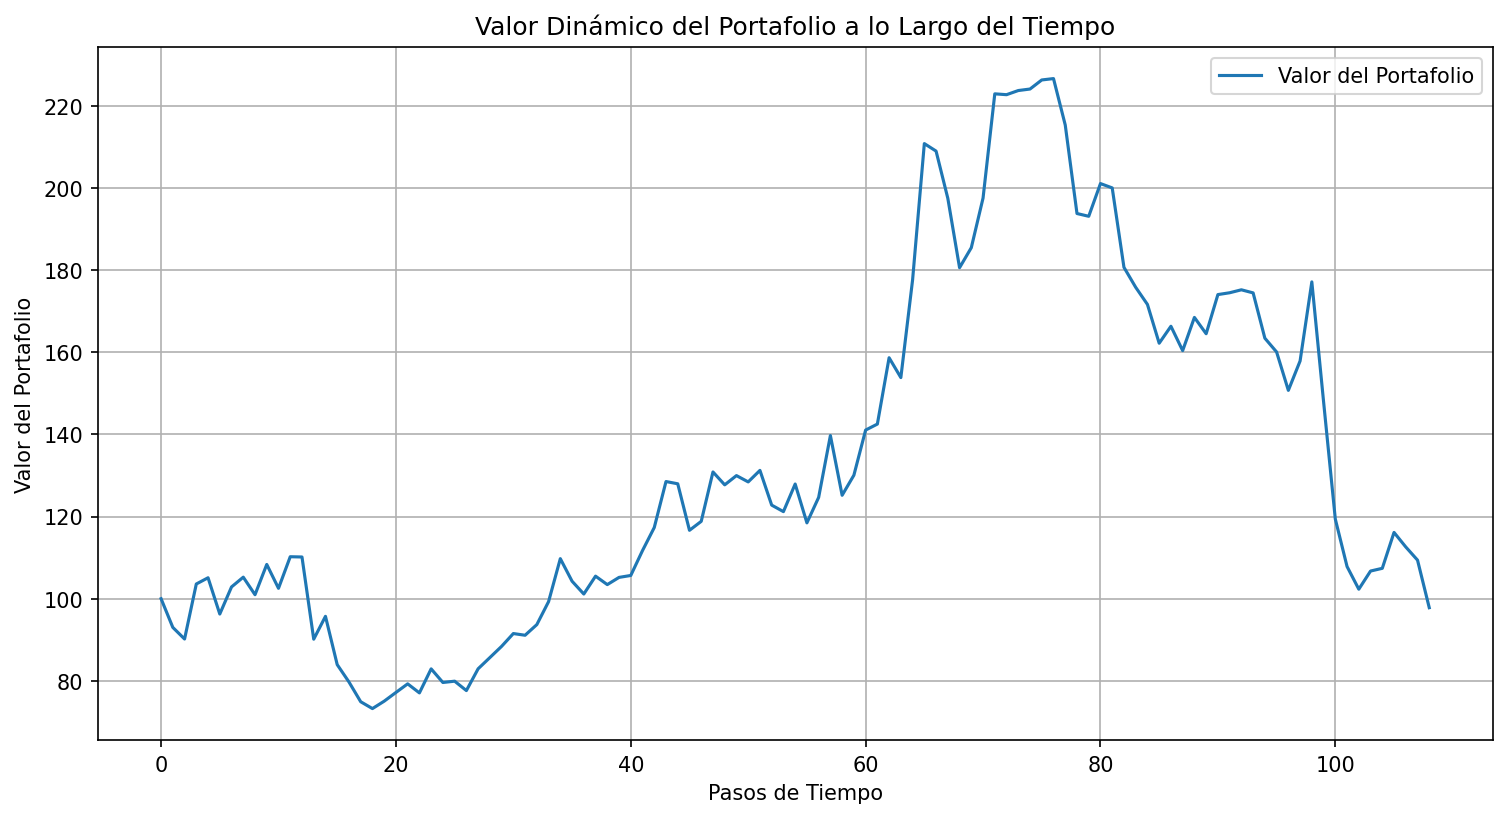

In [265]:
# Graficar valores del portafolio
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Valor del Portafolio")
plt.title("Valor Dinámico del Portafolio a lo Largo del Tiempo")
plt.xlabel("Pasos de Tiempo")
plt.ylabel("Valor del Portafolio")
plt.legend()
plt.grid()
plt.show()


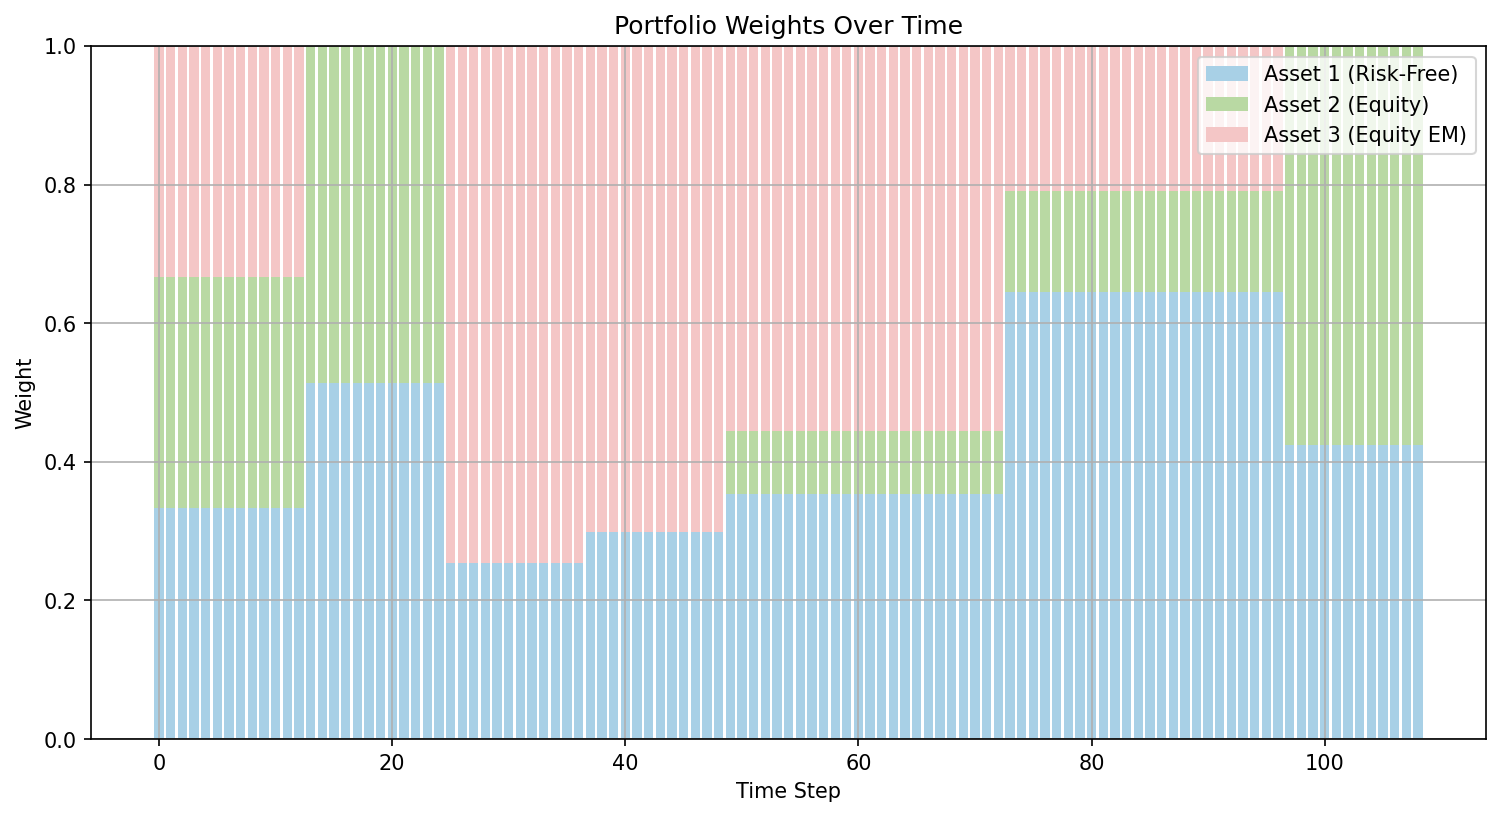

In [266]:
# Plot the portfolio weights over time
all_weights = np.array(all_weights)  # Convert list to array for easier plotting

plt.figure(figsize=(12, 6))
time_steps = np.arange(len(all_weights))

color1 = "#A8D0E6"  # Soft blue
color2 = "#B9D9A3"  # Soft green
color3 = "#F4C6C6"  # Soft pink

# Create a stacked bar plot for each time step with 3 bars (one for each asset)
plt.bar(time_steps, all_weights[:, 0], label="Asset 1 (Risk-Free)", color=color1)  # Asset 1
plt.bar(time_steps, all_weights[:, 1], bottom=all_weights[:, 0], label="Asset 2 (Equity)", color=color2)  # Asset 2 stacked on Asset 1
plt.bar(time_steps, all_weights[:, 2], bottom=all_weights[:, 0] + all_weights[:, 1], label="Asset 3 (Equity EM)", color=color3)  # Asset 3 stacked on Asset 1 and Asset 2

plt.title("Portfolio Weights Over Time")
plt.xlabel("Time Step")
plt.ylabel("Weight")
plt.legend()
plt.grid()
plt.show()

CAGR: -0.24%, Retorno Acumulado en 9.1 años: -2.19%
Volatilidad: 1.0884070758136737
El Sharpe Medio de la estrategia es 0.5567


TypeError: __init__() got an unexpected keyword argument 'ncols'

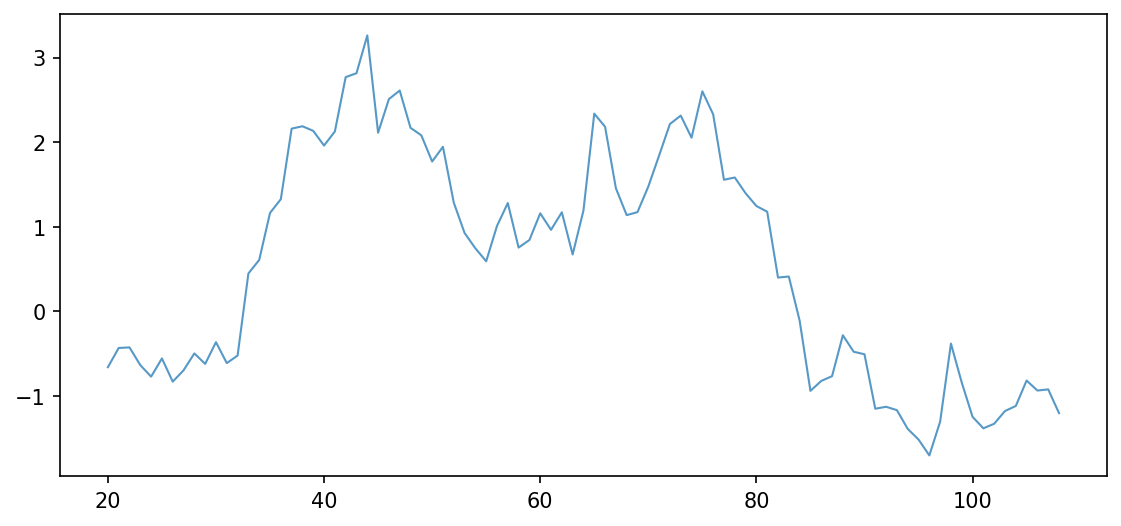

In [267]:
# Risk metrics
# Metricas de riesgo

portfolio_values = pd.Series(portfolio_values)

#retorno lineal
r = portfolio_values.pct_change()
#print(r)

# Daily returns plot 
#ADD

# retorno acumulado
r_st = (r+1).prod()-1
#print(f'Retorno acumulado: {r_st:.2%}')

# CAGR
n_obs = len(r)
years = n_obs / 12 # Convert to years assuming daily frequency

cagr = (1+r_st)**(1/years)-1
print(f"CAGR: {cagr:.2%}, Retorno Acumulado en {years:.1f} años: {r_st:.2%}")

# volatilidad
volatility = r.std() * 252**0.5
print(f'Volatilidad: {volatility}')


# sharpe w rolling
w, fr = 20, 0
roll_ret = portfolio_values.pct_change(w)
roll_std = (r.rolling(w).std() * (w**.5))

roll_sharpe = (roll_ret - fr) / roll_std

print(f'El Sharpe Medio de la estrategia es {roll_sharpe.mean():.4f}')

# Sharpe Ratio TTM
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots(figsize=(9,4))
roll_sharpe.plot(ax=ax, alpha=0.75,  lw=1, color='tab:blue')
ax.legend(frameon=False, fontsize=9, ncols=5)
ax.set_title('Sharpe Ratio TTM')
ax.grid(alpha=0.7)


# Sharpe Ratio, monthly rolling distribution
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots(figsize=(8,5))
roll_sharpe.hist(ax=ax, bins=20, alpha=0.25, density=True, label='Strategy', color='tab:blue')
roll_sharpe.plot.kde(ax=ax, label='Strategy KDE', color='tab:blue')
ax.axvline(0, ls='--', c='k', lw=0.5, label='Sharpe=0')
ax.axvline(roll_sharpe.mean(), ls='--',lw=0.5, label='Mean Sharpe Strategy', color='tab:blue')
ax.legend(frameon=False, fontsize=9)
ax.set_title('Sharpe Ratio, annual rolling distribution')
ax.set_xlim(-2,4)

# Sortino
def sortino(returns):
    semi_desv = (((returns[returns < 0] - returns[returns < 0].mean() ) **2).sum() /len(returns[returns < 0])) **.5
    return returns.mean() / semi_desv * (252**0.5)  

print(f'Sortino: {sortino(r)}')

# Max & Average DrawDown
mdd = abs((portfolio_values / portfolio_values.cummax()-1).min())
print(f'Max DrawDown: {mdd}')

add = (1-portfolio_values / portfolio_values.cummax()).mean()
print(f'Average DrawDown: {add}')

fig, ax = plt.subplots(figsize=(9,4))
st_plot = (portfolio_values / portfolio_values.cummax()-1)
st_plot.plot(ax=ax, lw=0.75, c='tab:blue', alpha=0.7, label='DD')
ax.axhline(-mdd, ls='--', lw=0.75, c='tab:blue', alpha=0.7, label='MDD')
ax.axhline(-add, ls='--', lw=1.75, c='tab:blue', alpha=0.7, label='ADD')
ax.legend(frameon=False, ncols=4, fontsize=8, loc='upper center', bbox_to_anchor=(0.5, 1.07))
ax.set_title('DrawDowns', y=1.05)
plt.xticks(fontsize=7) 
plt.yticks(fontsize=7) 
ax.set_xlabel('Fecha', fontsize=8)
ax.set_ylabel('Drawdown', fontsize=8)
ax.grid()


# CALMAR Ratio
calmar = cagr / -mdd
print(f'Calmar ratio: {calmar}')

# Recovery factor
def recoverFactor(prices):
    returns = prices.pct_change().dropna()
    retorno_acum = (returns+1).prod()-1
    dd_max = -1*(returns / returns.cummax()-1).min()
    return round(retorno_acum / dd_max, 2)
    
print(f'Recovery factor: {recoverFactor(portfolio_values)}')

# Riesgo de Ruina

def RoR(returns, capital=1):
    mu = returns.mean()
    sigma = returns.std()
    r = (mu**2 + sigma**2)**0.5
    return (2/(1+mu/r)-1)**(capital/r)

print(f"Riesgo Ruina estrategia {RoR(r):.4%}")


res=[]
for i in range(10000):
    capital = (i+1)/10000
    res.append({
     'Portfolio':RoR(r, capital), 
    })
res = pd.DataFrame(res)

plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(res.index/10000, res.Portfolio, color='tab:blue', label='Portfolio')
ax.set_title( f'Risk of Ruin')
plt.xticks(fontsize=7) 
plt.yticks(fontsize=7) 
ax.legend(frameon=False, fontsize=9, loc='upper right', ncols=4)
ax.set_xlabel('% del capital en riesgo', fontsize=8)
ax.set_ylabel('Riesgo de ruina', fontsize=8)
ax.set_xlim(0,1)
ax.grid()
